# Explore Physionet CTG Outcome Metadata Apgar 5

see: https://physionet.org/physiobank/database/ctu-uhb-ctgdb/

Includes:
- Plots of various outcome metrics vs apgar 5
- Regression models to predict apgar5 from other outcome metrics

In [1]:
import config_local
from config_common import *

In [2]:
import wfdb
import os
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from sklearn import svm
import math
import collections

In [3]:
from ctg_utils import get_all_recno, parse_meta_comments

In [4]:
import random

In [5]:
from sklearn.decomposition import PCA

# Config

# Code

In [6]:
def jitter(x, w=2):
    return x + (random.random()-0.5)/w

In [7]:
def display_metric_vs_apgar(metric, apgar, title='', xlabel='', ylabel='', 
                            limits=None, thresh=None):
    plt.figure(figsize=(5,5))
    if title:
        plt.title(title)
    plt.scatter(metric, [jitter(x) for x in apgar], s=3)
    if thresh:
        plt.plot([thresh, thresh], [0, 10], 'r--')
    plt.ylim(0, 10)
    if limits:
        plt.plot(limits, [7, 7], 'r--')
        plt.xlim(*limits)
    if ylabel:
        plt.ylabel(ylabel)
    if apgar:
        plt.xlabel(xlabel)
    plt.show()

In [8]:
def display_predictions(actual, pred, title=None, xlabel='Apgar 5'):
    all_error = [abs(val-pred[i])  for i, val in enumerate(actual)]
    print('Error -- mean: {:0.2f}   std: {:0.2f}'.format(np.mean(all_error), np.std(all_error)))
    
    
    plt.figure(figsize=(5,5))
    if title:
        plt.title(title)
    plt.scatter([jitter(x) for x in actual], [x for x in pred], s=3)
    plt.ylim(0, 10)
    plt.xlim(0, 10)
    plt.plot([0,10], [0, 10], 'g--', alpha=0.25)
    plt.plot([0,9.5], [0.5, 10], 'r--', alpha=0.25)
    plt.plot([0.5,10], [0, 9.5], 'r--', alpha=0.25)

    plt.plot([7,7], [0, 10], 'r--', alpha=0.25)
    plt.plot([0, 10], [7,7], 'r--', alpha=0.25)
    plt.ylabel('Predicted {}'.format(xlabel))
    plt.xlabel(xlabel)
    plt.show()

# Gather All Recording Metadata

In [9]:
all_meta = {}
all_error = []
for recno in sorted(get_all_recno(media_recordings_dir_full)):
    recno_full = os.path.join(media_recordings_dir_full, recno)
    #print('Record: {}'.format(recno))
    try:
        all_sig, meta = wfdb.io.rdsamp(recno_full)
        meta['comments'] = parse_meta_comments(meta['comments'])
        all_meta[recno] = meta['comments']
    except Exception as e:
        print('    Error: {}'.format(e))
        all_error.append(recno)

### Filter nan values

In [10]:
for recno in sorted(all_meta.keys()):
    entry = all_meta[recno]['Outcome']
    if math.isnan(entry['BDecf']):
        print('{}: Recording contains NaN'.format(recno))
        del all_meta[recno]

1044: Recording contains NaN
1070: Recording contains NaN
1211: Recording contains NaN
1215: Recording contains NaN
1356: Recording contains NaN
1373: Recording contains NaN
1383: Recording contains NaN
1419: Recording contains NaN
2006: Recording contains NaN
2034: Recording contains NaN
2046: Recording contains NaN


# Outcomes

In [11]:
for recno in sorted(all_meta.keys()):
    # recno = '1001'
    entry = all_meta[recno]['Outcome']
    print('{:4}: pH:{:5.2f}   BDecf: {:5.2f}    pCO2: {:5.2f}    BE: {:6.2f}    Apgar1: {:2}    Apgar5: {:2}'.format(
        recno, entry['pH'], entry['BDecf'], entry['pCO2'], entry['BE'], entry['Apgar1'], entry['Apgar5']))

1001: pH: 7.14   BDecf:  8.14    pCO2:  7.70    BE: -10.50    Apgar1:  6    Apgar5:  8
1002: pH: 7.00   BDecf:  7.92    pCO2: 12.00    BE: -12.00    Apgar1:  8    Apgar5:  8
1003: pH: 7.20   BDecf:  3.03    pCO2:  8.30    BE:  -5.60    Apgar1:  7    Apgar5:  9
1004: pH: 7.30   BDecf:  5.19    pCO2:  5.50    BE:  -6.40    Apgar1:  8    Apgar5:  9
1005: pH: 7.30   BDecf:  4.52    pCO2:  5.70    BE:  -5.80    Apgar1:  9    Apgar5: 10
1006: pH: 7.23   BDecf:  1.29    pCO2:  8.20    BE:  -3.80    Apgar1:  8    Apgar5:  9
1007: pH: 7.16   BDecf:  4.35    pCO2:  8.80    BE:  -6.80    Apgar1:  9    Apgar5: 10
1008: pH: 7.36   BDecf:  3.88    pCO2:  4.90    BE:  -4.60    Apgar1:  8    Apgar5:  9
1009: pH: 7.18   BDecf:  7.60    pCO2:  7.00    BE:  -9.60    Apgar1:  8    Apgar5:  9
1010: pH: 7.35   BDecf:  5.20    pCO2:  4.70    BE:  -5.90    Apgar1:  8    Apgar5:  9
1011: pH: 7.37   BDecf:  1.73    pCO2:  5.30    BE:  -2.60    Apgar1:  8    Apgar5:  9
1012: pH: 7.36   BDecf:  0.82    pCO2:  5.7

In [12]:
all_pH = [entry['Outcome']['pH'] for entry in all_meta.values()]
all_BDecf = [entry['Outcome']['BDecf'] for entry in all_meta.values()]
all_pCO2 = [entry['Outcome']['pCO2'] for entry in all_meta.values()]
all_BE = [entry['Outcome']['BE'] for entry in all_meta.values()]
all_Apgar1 = [entry['Outcome']['Apgar1'] for entry in all_meta.values()]
all_Apgar5 = [entry['Outcome']['Apgar5'] for entry in all_meta.values()]

all_pH_lin = [10**(entry['Outcome']['pH']-7) for entry in all_meta.values()]

## Show pH vs Apgar5

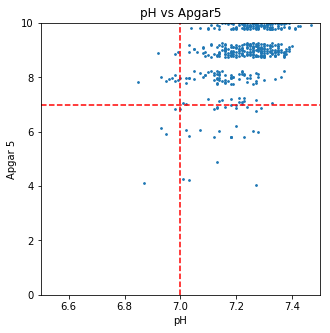

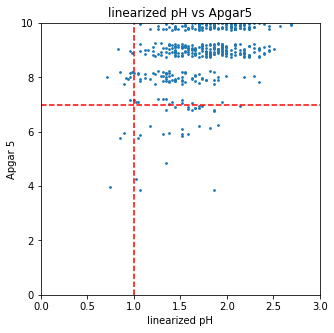

In [13]:
display_metric_vs_apgar(all_pH, all_Apgar5, limits=[6.5, 7.5],thresh=7,
                        title='pH vs Apgar5', xlabel='pH', ylabel='Apgar 5')   

display_metric_vs_apgar(all_pH_lin, all_Apgar5, limits=[0,3], thresh=1,
                        title='linearized pH vs Apgar5', xlabel='linearized pH', ylabel='Apgar 5')  

## Show BDecf vs Apgar5

-3.4 26.11


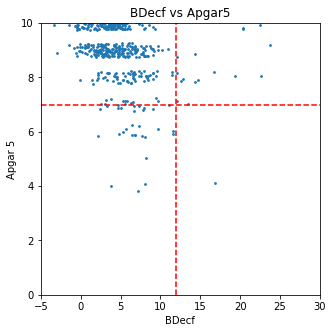

In [14]:
print(np.min(all_BDecf), np.max(all_BDecf))

display_metric_vs_apgar(all_BDecf, all_Apgar5, limits=[-5, 30], thresh=12,
                        title='BDecf vs Apgar5', xlabel='BDecf', ylabel='Apgar 5') 

### Drilldown:  BDecf vs Apgar5 for pH normal and abnormal pH

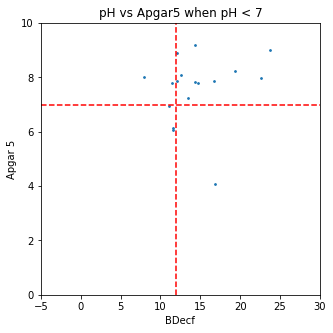

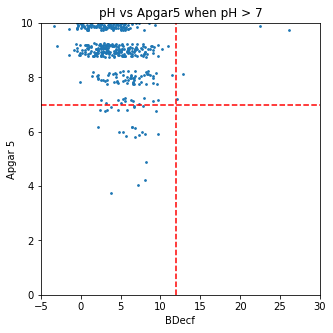

In [15]:
idx_subset = [i for i, x in enumerate(all_pH) if x <= 7]
display_metric_vs_apgar([all_BDecf[i] for i in idx_subset], [all_Apgar5[i] for i in idx_subset], 
                        limits=[-5, 30], thresh=12,
                        title='pH vs Apgar5 when pH < 7', xlabel='BDecf', ylabel='Apgar 5') 

idx_subset = [i for i, x in enumerate(all_pH) if x > 7]
display_metric_vs_apgar([all_BDecf[i] for i in idx_subset], [all_Apgar5[i] for i in idx_subset], 
                        limits=[-5, 30], thresh=12,
                        title='pH vs Apgar5 when pH > 7', xlabel='BDecf', ylabel='Apgar 5') 

## Show BE vs Apgar5

-26.8 -0.2


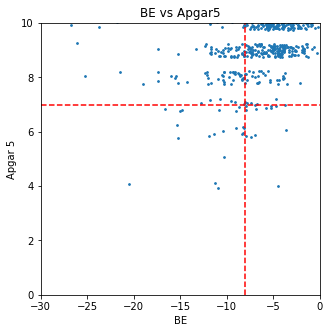

In [16]:
print(np.min(all_BE), np.max(all_BE))
display_metric_vs_apgar(all_BE, all_Apgar5, limits=[-30, 0], thresh=-8,
                        title='BE vs Apgar5', xlabel='BE', ylabel='Apgar 5') 

### Drilldown:  BE vs Apgar5 for pH normal and abnormal pH

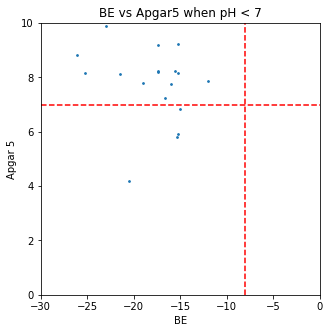

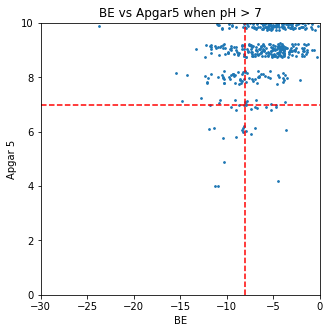

In [17]:
idx_subset = [i for i, x in enumerate(all_pH) if x <= 7]

display_metric_vs_apgar([all_BE[i] for i in idx_subset], [all_Apgar5[i] for i in idx_subset], 
                        limits=[-30, 0], thresh=-8,
                        title='BE vs Apgar5 when pH < 7', xlabel='BE', ylabel='Apgar 5') 

idx_subset = [i for i, x in enumerate(all_pH) if x > 7]
display_metric_vs_apgar([all_BE[i] for i in idx_subset], [all_Apgar5[i] for i in idx_subset], 
                        limits=[-30, 0], thresh=-8,
                        title='BE vs Apgar5 when pH > 7', xlabel='BE', ylabel='Apgar 5') 


## PCA

In [18]:
all_features = list(zip(all_Apgar5, all_BE, all_pH_lin, all_pH))

In [19]:
# Determine feature count by APGAR
counts = collections.defaultdict(int)
feature_by_apgar = collections.defaultdict(list)
for i, x in enumerate(all_Apgar5):
    counts[x] += 1
    feature_by_apgar[x].append(all_features[i])

for k in sorted(counts.keys()):
    print(k, counts[k])

# equalize feature set without replace

max_entries = 14
train_features = []
train_labels = []

for k, v in feature_by_apgar.items():
    if len(v) <= max_entries:
        train_features += v
        train_labels += [k] * len(v)
    else:
        train_labels += [k] * max_entries
        for i in np.random.choice(np.arange(len(v)), size=max_entries, replace=False):
            train_features.append(v[i])
        
train_features = np.vstack(train_features)

4 4
5 1
6 14
7 26
8 71
9 200
10 225


Error -- mean: 1.34   std: 0.86


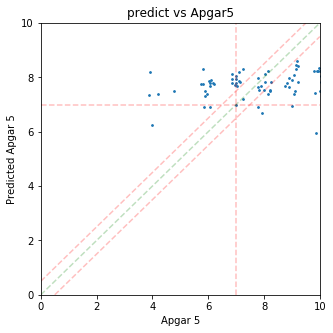

In [20]:
n_components = 1

pca = PCA(n_components=n_components)
pca.fit(train_features)
predict = pca.inverse_transform((pca.transform(train_features)))

display_predictions(train_labels, [x[0] for x in predict], title='predict vs Apgar5')

In [21]:
pca.components_

array([[-0.12138988, -0.98962742, -0.07341247, -0.02264235]])

In [22]:
pca.explained_variance_ratio_ 

array([0.8651614])

In [23]:
print('  all_Apgar5,  all_BE,     all_pH_lin  all_pH')
print(pca.get_covariance())

  all_Apgar5,  all_BE,     all_pH_lin  all_pH
[[ 1.12014946  1.93524394  0.14356013  0.04427774]
 [ 1.93524394 16.65978738  1.17036969  0.36097297]
 [ 0.14356013  1.17036969  0.96958845  0.02677767]
 [ 0.04427774  0.36097297  0.02677767  0.89102711]]


### Try again ignoring pH (log version)

Conclusion:  (log) pH has little impact on estimate

In [24]:
# strip pH from training set
train_features = [x[:-1] for x in train_features]

Error -- mean: 1.34   std: 0.86


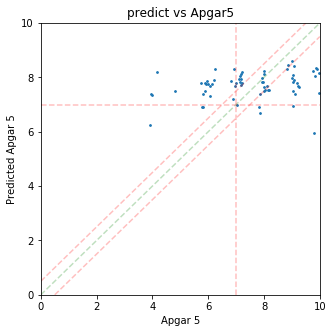

In [25]:
n_components = 1

pca = PCA(n_components=n_components)
pca.fit(train_features)
predict = pca.inverse_transform((pca.transform(train_features)))

display_predictions(train_labels, [x[0] for x in predict], title='predict vs Apgar5')

In [26]:
pca.components_

array([[-0.12137956, -0.98988739, -0.07341633]])

In [27]:
pca.explained_variance_ratio_ 

array([0.86524021])

In [28]:
print('  all_Apgar5,  all_BE,     all_pH_lin  all_pH')
print(pca.get_covariance())

  all_Apgar5,  all_BE,     all_pH_lin  all_pH
[[ 1.55331243  1.88169697  0.13955859]
 [ 1.88169697 16.66839324  1.13814297]
 [ 0.13955859  1.13814297  1.40699148]]


# Modeling:  Estimate Apgar5 using Outcome Metrics

In [29]:
# Determine feature count by APGAR
counts = collections.defaultdict(int)
feature_by_apgar5 = collections.defaultdict(list)
for i, x in enumerate(all_Apgar5):
    counts[x] += 1
    feature_by_apgar5[x].append(all_features[i])

for k in sorted(counts.keys()):
    print(k, counts[k])

4 4
5 1
6 14
7 26
8 71
9 200
10 225


In [30]:
all_features = list(zip(all_pH, all_BDecf, all_pCO2, all_BE, all_pH_lin))

## SVM Regression #1
Without Replacement (limit number of features by apgar)

In [31]:
# Determine feature count by APGAR
counts = collections.defaultdict(int)
feature_by_apgar5 = collections.defaultdict(list)
for i, x in enumerate(all_Apgar5):
    counts[x] += 1
    feature_by_apgar5[x].append(all_features[i])

for k in sorted(counts.keys()):
    print(k, counts[k])

4 4
5 1
6 14
7 26
8 71
9 200
10 225


In [32]:
max_entries = 14
train_features = []
train_labels = []

for k, v in feature_by_apgar5.items():
    if len(v) <= max_entries:
        train_features += v
        train_labels += [k] * len(v)
    else:
        train_labels += [k] * max_entries
        for i in np.random.choice(np.arange(len(v)), size=max_entries, replace=False):
            train_features.append(v[i])
        
train_features = np.vstack(train_features)
train_features.shape, len(train_labels)

((75, 5), 75)

### Use SVM

In [33]:
clf = svm.LinearSVR(max_iter=100000)
clf.fit(train_features, train_labels) 

pred_train = clf.predict(train_features) 
pred_test = clf.predict(all_features) 

Error -- mean: 1.14   std: 0.85


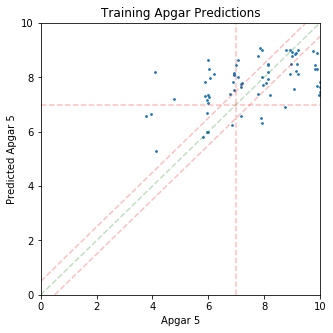

Error -- mean: 1.12   std: 0.77


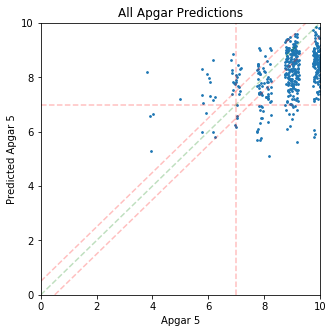

In [34]:
display_predictions(train_labels, pred_train, title='Training Apgar Predictions')
display_predictions(all_Apgar5, pred_test, title='All Apgar Predictions')

## SVM Regression #2
With Replacement (feature set for sames features for each apgar score)

In [35]:
# Trtaining Set Using Replacement

max_entries = 50
train_features = []
train_labels = []

for k, v in feature_by_apgar5.items():
    train_labels += [k] * max_entries
    for i in np.random.choice(np.arange(len(v)), size=max_entries, replace=True):
        train_features.append(v[i])
        
train_features = np.vstack(train_features)
train_features.shape, len(train_labels)

((350, 5), 350)

In [36]:
#clf = svm.LinearSVR(max_iter=100000)
clf = svm.SVR(max_iter=100000, gamma='scale')
clf.fit(train_features, train_labels) 

pred_train = clf.predict(train_features) 

pred_test = clf.predict(all_features) 

Error -- mean: 1.31   std: 1.13


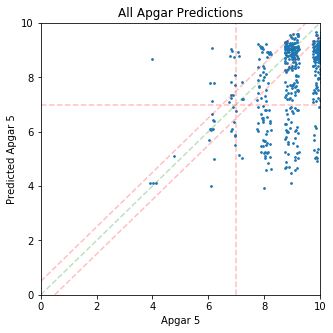

In [37]:
display_predictions(all_Apgar5, pred_test, title='All Apgar Predictions')